In [ ]:
!pip install pyvi timm
import os
import zipfile
import json
import random
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torchvision import transforms, models
from PIL import Image
from pyvi import ViTokenizer
from transformers import BlipProcessor, BlipForQuestionAnswering
from google.colab import drive
import timm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.image as mpimg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 859.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [ ]:
drive.mount('/content/drive')
project_dir = "/content/drive/MyDrive/Project_Gki"
os.makedirs(project_dir, exist_ok=True)
zip_path = os.path.join(project_dir, "StanfordCars.zip")
extracted_dir = "/content/stanford_cars"

if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Đã giải nén StanfordCars.zip")
else:
    print("Thư mục stanford_cars đã tồn tại, không cần giải nén.")

Mounted at /content/drive
Đã giải nén StanfordCars.zip


In [ ]:
# @title
import torch
import json
import os
import pandas as pd
import random
from PIL import Image
from tqdm.notebook import tqdm
import concurrent.futures
from transformers import BlipProcessor, BlipForQuestionAnswering

# === Cấu hình đường dẫn ===
TRAIN_DIR = "/content/stanford_cars/cars_train/cars_train"
OUTPUT_FILE = "/content/VQA_dataset.json"
CHECKPOINT_DIR = "/content/checkpoints"
CSV_FILE = "/content/train_data.csv"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# === Danh sách câu hỏi chọn lọc ===
QUESTIONS = {
    "What type of car is this?": "Đây là loại xe gì?",
    "What is the color of the car?": "Màu sắc của xe là gì?",
    "What brand manufactured this car?": "Xe này được sản xuất bởi hãng nào?",
    "Where is the car located in the image?": "Xe trong ảnh đang ở đâu?",
    "Is this a luxury car?": "Đây có phải là xe sang không?",
    "Is this a sports car?": "Đây có phải là xe thể thao không?",
    "What is the country of origin for this car brand?": "Hãng xe này có xuất xứ từ quốc gia nào?",
    "How would you rate this car's design?": "Bạn đánh giá thế nào về thiết kế của xe này?"
}

# === Trích xuất loại xe từ tên ===
def extract_car_type_from_name(full_name):
    """Trích xuất loại xe trực tiếp từ tên đầy đủ của xe trong CSV"""
    full_name_lower = full_name.lower()

    # Kiểm tra các từ khóa rõ ràng trong tên
    if "suv" in full_name_lower:
        return "SUV"
    elif "convertible" in full_name_lower:
        return "xe mui trần"
    elif "coupe" in full_name_lower:
        return "coupe"
    elif "hatchback" in full_name_lower:
        return "hatchback"
    elif "wagon" in full_name_lower:
        return "wagon"
    elif "minivan" in full_name_lower:
        return "minivan"
    elif "van" in full_name_lower:
        return "xe van"
    elif any(term in full_name_lower for term in ["crew cab", "pickup", "quad cab"]):
        return "xe bán tải"

    # Phân loại dựa trên từ điển mẫu xe
    car_models_by_type = {
        "SUV": [
            "escape", "explorer", "equinox", "tahoe", "suburban", "escalade",
            "pathfinder", "4runner", "highlander", "rav4", "cr-v", "pilot",
            "sorento", "sportage", "tucson", "santa fe", "x3", "x5", "q5", "q7",
            "cayenne", "grand cherokee", "wrangler", "rogue", "murano",
            "traverse", "terrain", "edge", "trax", "enclave", "envision",
            "expedition", "sequoia", "land cruiser", "armada", "telluride"
        ],
        "sedan": [
            "accord", "camry", "civic", "corolla", "altima", "sentra", "maxima",
            "malibu", "impala", "sonata", "elantra", "optima", "forte", "jetta",
            "passat", "legacy", "impreza", "fusion", "taurus", "focus", "cruze",
            "a3", "a4", "a6", "a8", "3 series", "5 series", "7 series", "es", "ls",
            "c-class", "e-class", "s-class", "cts", "ats", "xts", "charger", "300",
            "mazda3", "mazda6", "avalon", "clarity", "insight", "model 3"
        ],
        "coupe": [
            "mustang", "camaro", "challenger", "corvette", "911", "370z", "86",
            "brz", "r8", "tl type-s", "g37", "q60", "rcf", "gt-r", "f-type",
            "cayman", "continental gt", "amg gt", "m4", "tt", "lc", "nsx"
        ],
        "xe mui trần": [
            "miata", "mx-5", "boxster", "911 cabriolet", "a5 cabriolet",
            "4 series convertible", "slk", "sl", "z4", "f-type convertible",
            "corvette convertible", "camaro convertible", "mustang convertible"
        ],
        "hatchback": [
            "golf", "focus", "fit", "civic hatchback", "mazda3 hatchback",
            "impreza hatchback", "veloster", "elantra gt", "fiesta",
            "versa note", "yaris", "rio", "spark", "500", "a3 sportback",
            "leaf", "prius", "bolt", "sonic", "accent"
        ],
        "xe bán tải": [
            "f-150", "silverado", "ram 1500", "sierra", "tundra", "tacoma",
            "ranger", "colorado", "canyon", "frontier", "ridgeline", "titan"
        ],
        "xe van": [
            "odyssey", "sienna", "pacifica", "grand caravan", "sedona",
            "transit", "sprinter", "metris", "express", "nv"
        ]
    }

    # Tìm kiếm tên model trong danh sách mẫu xe
    for car_type, models in car_models_by_type.items():
        for model in models:
            if model in full_name_lower:
                return car_type

    # Phân loại theo hãng và các quy tắc đặc biệt
    parts = full_name_lower.split()
    make = parts[0] if parts else ""

    # SUV theo hãng
    if make in ["jeep", "land"]:
        return "SUV"

    # Xe thể thao theo hãng
    if make in ["ferrari", "lamborghini", "bugatti", "maserati"]:
        if "suv" not in full_name_lower:  # Trừ SUV như Ferrari Purosangue
            return "xe thể thao"

    # Nếu có số cửa, dùng để phân biệt sedan và coupe
    if "4 door" in full_name_lower or "4-door" in full_name_lower:
        return "sedan"
    if "2 door" in full_name_lower or "2-door" in full_name_lower:
        return "coupe"

    # Từ khóa từ cách gọi
    if "crossover" in full_name_lower:
        return "SUV"

    # Mặc định là sedan (loại xe phổ biến nhất)
    return "sedan"

# === Tải metadata từ CSV ===
def load_metadata_from_csv(csv_path):
    """Tải metadata từ file CSV với bounding box"""
    print(f"Đang tải metadata từ CSV: {csv_path}")

    # Đọc file CSV
    df = pd.read_csv(csv_path)
    print(f"Đọc được {len(df)} dòng từ file CSV")

    # Tạo car_info_map từ CSV
    car_info_map = {}
    car_class_map = {}

    for _, row in df.iterrows():
        image_name = row['image']
        class_id = row['class']
        class_name = row['ture_class_name']

        # Lấy bounding box nếu có
        bbox = None
        if 'x1' in df.columns and 'y1' in df.columns and 'x2' in df.columns and 'y2' in df.columns:
            bbox = [row['x1'], row['y1'], row['x2'], row['y2']]

        # Phân tích tên class để lấy thông tin
        car_info = parse_car_info_from_classname(class_name, class_id)

        # Thêm bounding box nếu có
        if bbox:
            car_info['bbox'] = bbox

        # Lưu vào car_info_map
        car_info_map[image_name] = car_info
        car_class_map[class_id] = car_info

    print(f"Đã tạo ánh xạ cho {len(car_info_map)} file ảnh")

    return car_info_map, car_class_map

# === Phân tích thông tin xe từ tên class ===
def parse_car_info_from_classname(class_name, class_id):
    """Trích xuất thông tin xe từ tên class đầy đủ sử dụng phương pháp cải tiến"""
    # Ví dụ: "BMW 1 Series Convertible 2012" -> make="BMW", model="1 Series Convertible", year="2012"
    parts = class_name.split()
    year = parts[-1] if parts[-1].isdigit() else ""

    # Xác định hãng xe
    make = parts[0]
    if make == "AM":
        make = "AM General"
    elif make == "Aston":
        make = "Aston Martin"
    elif make == "Land":
        make = "Land Rover"

    # Xác định model (phần còn lại giữa hãng và năm)
    if year:
        model = " ".join(parts[1:-1])
    else:
        model = " ".join(parts[1:])

    # Xác định loại xe trực tiếp từ tên đầy đủ - SỬ DỤNG HÀM TRÍCH XUẤT
    car_type = extract_car_type_from_name(class_name)

    # Xác định xe sang và xe thể thao
    luxury_brands = {
        "Mercedes-Benz", "BMW", "Audi", "Lexus", "Porsche",
        "Bentley", "Rolls-Royce", "Maserati", "Jaguar", "Land Rover",
        "Aston Martin", "Lamborghini", "Ferrari", "Tesla", "Maybach"
    }

    is_luxury = make in luxury_brands
    is_sports = any(keyword in class_name.lower() for keyword in [
        "ferrari", "lamborghini", "porsche", "mclaren", "bugatti",
        "corvette", "viper", "gt-r", "r8", "aventador", "gallardo",
        "zr1", "superleggera", "srt", "sports car", "z06"
    ]) or "xe thể thao" == car_type

    return {
        'make': make,
        'model': model,
        'year': year,
        'car_type': car_type,
        'is_luxury': is_luxury,
        'is_sports': is_sports,
        'full_name': class_name,
        'class_id': class_id
    }

# === Tải BLIP model ===
def load_blip_model():
    """Tải mô hình BLIP"""
    print("Đang tải mô hình BLIP...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
        model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
        print(f"Mô hình BLIP đã được tải")
        return processor, model, device
    except Exception as e:
        print(f"Lỗi khi tải mô hình BLIP: {str(e)}")
        raise e

# === Xử lý màu sắc và vị trí ===
def extract_color(blip_answer):
    """Trích xuất màu sắc từ câu trả lời BLIP"""
    answer_lower = blip_answer.lower()

    color_map = {
        "red": "đỏ", "blue": "xanh dương", "green": "xanh lá",
        "black": "đen", "white": "trắng", "silver": "bạc",
        "gray": "xám", "grey": "xám", "yellow": "vàng",
        "brown": "nâu", "orange": "cam", "pink": "hồng",
        "purple": "tím", "gold": "vàng đồng", "beige": "be",
        "burgundy": "đỏ đô", "maroon": "đỏ đô", "tan": "nâu nhạt"
    }

    # Nếu tìm thấy màu cụ thể trong câu trả lời BLIP
    for eng_color, vn_color in color_map.items():
        if eng_color in answer_lower:
            return f"Xe có màu {vn_color}."

    # Tìm kiếm theo cấu trúc câu
    if "color" in answer_lower:
        words = answer_lower.split()
        try:
            color_index = words.index("color")
            if color_index > 0 and words[color_index-1] not in ["the", "a"]:
                potential_color = words[color_index-1]
                if len(potential_color) > 2:
                    return f"Xe có màu {potential_color}."
            elif color_index < len(words) - 2 and words[color_index+1] == "is":
                if color_index < len(words) - 2:
                    potential_color = words[color_index+2]
                    if len(potential_color) > 2:
                        return f"Xe có màu {potential_color}."
        except ValueError:
            pass

    # Mặc định
    return "Không thể xác định chính xác màu sắc của xe từ hình ảnh này."

def extract_location_improved(blip_answer, bbox=None):
    """Phiên bản cải tiến để xác định vị trí xe chính xác hơn"""
    answer_lower = blip_answer.lower()

    # Từ điển vị trí với mẫu câu trả lời phong phú
    location_types = {
        # Vị trí ngoài trời
        "street": "Xe đang di chuyển trên đường phố.",
        "road": "Xe đang chạy trên đường.",
        "highway": "Xe đang lưu thông trên đường cao tốc.",
        "parking lot": "Xe đang đỗ trong bãi đỗ xe.",
        "parked": "Xe đang đỗ tại bãi xe.",
        "driveway": "Xe đậu tại lối vào nhà.",
        "outdoor": "Xe đang ở ngoài trời.",
        "city": "Xe đang trên đường phố trong thành phố.",
        "beach": "Xe đang ở gần bãi biển.",
        "field": "Xe đang di chuyển trên cánh đồng hoặc địa hình tự nhiên.",
        "forest": "Xe đang di chuyển trên đường trong rừng.",

        # Vị trí trong nhà/trưng bày
        "dealership": "Xe đang được trưng bày tại đại lý xe hơi.",
        "showroom": "Xe đang được trưng bày trong phòng trưng bày.",
        "garage": "Xe đang đỗ trong nhà để xe.",
        "indoor": "Xe đang được đặt trong một không gian trong nhà.",
        "studio": "Xe đang được chụp ảnh trong studio chuyên nghiệp.",
        "exhibition": "Xe đang được trưng bày tại triển lãm xe hơi.",
        "car show": "Xe đang tham gia một buổi triển lãm xe.",
        "display": "Xe đang được trưng bày để giới thiệu.",

        # Hoạt động đặc biệt
        "racing": "Xe đang tham gia đua xe trên đường đua.",
        "track": "Xe đang chạy trên đường đua."
    }

    # Kiểm tra từng từ khóa vị trí
    for keyword, response in location_types.items():
        if keyword in answer_lower:
            return response

    # Phân tích đặc biệt cho các mẫu câu phổ biến từ BLIP
    if "the car is in" in answer_lower or "the car is at" in answer_lower:
        location_part = answer_lower.replace("the car is in", "").replace("the car is at", "").strip()
        if location_part:
            return f"Xe đang ở {location_part}."

    # Phân tích bounding box để hỗ trợ xác định vị trí
    if bbox and all(x is not None for x in bbox):
        x1, y1, x2, y2 = bbox
        width, height = x2 - x1, y2 - y1
        area_ratio = (width * height) / (1.0 * 1.0)  # Giả sử ảnh có kích thước chuẩn hóa

        if area_ratio > 0.7:
            return "Xe được chụp cận cảnh, chiếm phần lớn khung hình."
        elif area_ratio < 0.3:
            return "Xe chỉ chiếm một phần nhỏ của bức ảnh, có thể đang được chụp từ xa."

    # Stanford Cars thường có hình ảnh xe trong các bãi đỗ xe hoặc khu vực trưng bày
    return "Xe đang đỗ trong bãi xe hoặc khu vực trưng bày."

# === Tạo câu trả lời chính xác - ĐÃ SỬA ĐỂ TRẢ VỀ NGUỒN DỮ LIỆU ===
def generate_accurate_answer(question_en, blip_answer, image_file, car_info_map):
    """Tạo câu trả lời chính xác dựa trên metadata và BLIP"""

    # Lấy bounding box nếu có
    bbox = None
    if image_file in car_info_map and 'bbox' in car_info_map[image_file]:
        bbox = car_info_map[image_file]['bbox']

    # Loại xe
    if question_en == "What type of car is this?":
        if image_file in car_info_map and 'car_type' in car_info_map[image_file]:
            return f"Đây là {car_info_map[image_file]['car_type']}.", "metadata"

        # Fallback to BLIP
        answer_lower = blip_answer.lower()
        car_types = {
            "suv": "SUV", "sedan": "sedan", "convertible": "xe mui trần",
            "coupe": "coupe", "hatchback": "hatchback", "wagon": "wagon",
            "minivan": "minivan", "truck": "xe bán tải", "van": "xe van"
        }

        for en_type, vn_type in car_types.items():
            if en_type in answer_lower:
                return f"Đây là {vn_type}.", "blip"

        return "Đây là sedan, loại xe phổ biến nhất.", "blip"

    # Hãng sản xuất
    elif question_en == "What brand manufactured this car?":
        if image_file in car_info_map and 'make' in car_info_map[image_file]:
            make = car_info_map[image_file]['make']
            return f"Xe này được sản xuất bởi hãng {make}.", "metadata"

        # Fallback to BLIP
        return "Không thể xác định chính xác hãng sản xuất xe này.", "blip"

    # Xe sang
    elif question_en == "Is this a luxury car?":
        if image_file in car_info_map and 'is_luxury' in car_info_map[image_file]:
            is_luxury = car_info_map[image_file]['is_luxury']
            if is_luxury:
                return "Có, đây là xe sang với thiết kế cao cấp và nhiều tính năng hiện đại.", "metadata"
            else:
                return "Không, đây không phải là xe sang mà thuộc phân khúc phổ thông.", "metadata"

        # Fallback to BLIP
        answer_lower = blip_answer.lower()
        if any(word in answer_lower for word in ["yes", "luxury", "expensive"]):
            return "Có, đây là xe sang với thiết kế cao cấp và nhiều tính năng hiện đại.", "blip"
        elif any(word in answer_lower for word in ["no", "not", "isn't"]):
            return "Không, đây không phải là xe sang mà thuộc phân khúc phổ thông.", "blip"

        return "Không đủ thông tin để xác định chắc chắn đây có phải là xe sang không.", "blip"

    # Xe thể thao
    elif question_en == "Is this a sports car?":
        if image_file in car_info_map and 'is_sports' in car_info_map[image_file]:
            is_sports = car_info_map[image_file]['is_sports']
            if is_sports:
                return "Có, đây là xe thể thao với hiệu suất cao và thiết kế khí động học.", "metadata"
            else:
                return "Không, đây không phải là xe thể thao.", "metadata"

        # Fallback to BLIP
        answer_lower = blip_answer.lower()
        if "yes" in answer_lower or "sport" in answer_lower:
            return "Có, đây là xe thể thao với hiệu suất cao và thiết kế khí động học.", "blip"
        elif "no" in answer_lower:
            return "Không, đây không phải là xe thể thao.", "blip"

        return "Không đủ thông tin để xác định chắc chắn đây có phải là xe thể thao không.", "blip"

    # Màu sắc - LUÔN DÙNG BLIP VÌ METADATA KHÔNG CÓ
    elif question_en == "What is the color of the car?":
        return extract_color(blip_answer), "blip"  # ĐÃ SỬA: đánh dấu nguồn là BLIP

    # Vị trí - LUÔN DÙNG BLIP VÌ METADATA KHÔNG CÓ
    elif question_en == "Where is the car located in the image?":
        return extract_location_improved(blip_answer, bbox), "blip"  # ĐÃ SỬA: đánh dấu nguồn là BLIP

    # Xuất xứ hãng xe
    elif question_en == "What is the country of origin for this car brand?":
        if image_file not in car_info_map:
            return "Không thể xác định xuất xứ của hãng xe này.", "blip"

        make = car_info_map[image_file].get('make', '')

        # Từ điển xuất xứ hãng xe
        brand_origin = {
            "Toyota": "Nhật Bản",
            "Honda": "Nhật Bản",
            "Nissan": "Nhật Bản",
            "Mazda": "Nhật Bản",
            "Subaru": "Nhật Bản",
            "Lexus": "Nhật Bản",
            "Mitsubishi": "Nhật Bản",
            "Suzuki": "Nhật Bản",
            "Acura": "Nhật Bản",
            "Infiniti": "Nhật Bản",

            "Hyundai": "Hàn Quốc",
            "Kia": "Hàn Quốc",
            "Genesis": "Hàn Quốc",

            "Volkswagen": "Đức",
            "BMW": "Đức",
            "Mercedes-Benz": "Đức",
            "Audi": "Đức",
            "Porsche": "Đức",
            "Opel": "Đức",

            "Ford": "Mỹ",
            "Chevrolet": "Mỹ",
            "Buick": "Mỹ",
            "Cadillac": "Mỹ",
            "Chrysler": "Mỹ",
            "Dodge": "Mỹ",
            "Jeep": "Mỹ",
            "Lincoln": "Mỹ",
            "Tesla": "Mỹ",
            "GMC": "Mỹ",
            "AM General": "Mỹ",

            "Fiat": "Ý",
            "Ferrari": "Ý",
            "Lamborghini": "Ý",
            "Maserati": "Ý",
            "Alfa Romeo": "Ý",

            "Renault": "Pháp",
            "Peugeot": "Pháp",
            "Citroen": "Pháp",
            "Bugatti": "Pháp",

            "Volvo": "Thụy Điển",
            "Koenigsegg": "Thụy Điển",

            "Land Rover": "Anh",
            "Jaguar": "Anh",
            "Bentley": "Anh",
            "Aston Martin": "Anh",
            "Rolls-Royce": "Anh",
            "Mini": "Anh"
        }

        if make in brand_origin:
            return f"Hãng xe {make} có xuất xứ từ {brand_origin[make]}.", "metadata"

        return f"Không có thông tin về xuất xứ của hãng xe {make}.", "blip"

    # Đánh giá thiết kế
    elif question_en == "How would you rate this car's design?":
        if image_file in car_info_map:
            car_info = car_info_map[image_file]
            make = car_info.get('make', '')
            is_luxury = car_info.get('is_luxury', False)
            is_sports = car_info.get('is_sports', False)
            car_type = car_info.get('car_type', '')

            if make in ["Ferrari", "Lamborghini", "Porsche", "Maserati", "Bugatti", "McLaren", "Aston Martin"]:
                return "Thiết kế của xe này rất ấn tượng và đẳng cấp, thể hiện sự sang trọng và hiệu suất cao.", "metadata"
            elif is_luxury:
                return "Thiết kế của xe này sang trọng và tinh tế, thể hiện đẳng cấp cao cấp.", "metadata"
            elif is_sports:
                return "Thiết kế của xe này mang tính thể thao và khí động học, tập trung vào hiệu suất và tốc độ.", "metadata"
            elif car_type == "SUV":
                return "Thiết kế của xe này mạnh mẽ và khỏe khoắn, phù hợp với đặc tính một chiếc SUV.", "metadata"
            elif car_type == "xe mui trần":
                return "Thiết kế của xe này năng động và thời trang, đặc trưng của dòng xe mui trần.", "metadata"
            elif car_type == "coupe":
                return "Thiết kế của xe này thể thao và mượt mà với đường nét khí động học.", "metadata"
            else:
                return "Thiết kế của xe này hiện đại và cân đối, phù hợp với phân khúc của nó.", "metadata"

        # Fallback to BLIP
        answer_lower = blip_answer.lower()
        design_words = {
            "beautiful": "đẹp và ấn tượng",
            "sleek": "mượt mà và hiện đại",
            "elegant": "thanh lịch và tinh tế",
            "sporty": "thể thao và năng động",
            "aggressive": "mạnh mẽ và táo bạo",
            "classic": "cổ điển và bền vững"
        }

        for en_word, vi_desc in design_words.items():
            if en_word in answer_lower:
                return f"Thiết kế của xe này {vi_desc}.", "blip"

        return "Thiết kế của xe này hiện đại và phù hợp với phân khúc của nó.", "blip"

    # Mặc định cho các câu hỏi khác
    return blip_answer, "blip"

# === Xử lý một ảnh - ĐÃ CẬP NHẬT ĐỂ SỬ DỤNG NGUỒN DỮ LIỆU CHÍNH XÁC ===
def process_single_image(args):
    """Xử lý một ảnh để tạo cặp câu hỏi-trả lời"""
    image_path, processor, model, device, car_info_map = args
    image_file = os.path.basename(image_path)
    qa_pairs = []

    try:
        image = Image.open(image_path).convert('RGB')

        for question_en, question_vi in QUESTIONS.items():
            try:
                # Xử lý BLIP
                inputs = processor(image, question_en, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model.generate(**inputs, max_length=30)
                    answer_en = processor.decode(outputs[0], skip_special_tokens=True)

                # Tạo câu trả lời chính xác dựa trên metadata và BLIP
                answer_vi, source = generate_accurate_answer(question_en, answer_en, image_file, car_info_map)

                # Thêm vào danh sách QA với nguồn dữ liệu được xác định chính xác
                qa_pairs.append({
                    "image": image_file,
                    "question": question_vi,
                    "answer": answer_vi,
                    "metadata": {
                        "blip_answer": answer_en,
                        "true_answer_source": source
                    }
                })

            except Exception as e:
                print(f"Lỗi với câu hỏi '{question_en}' cho ảnh {image_file}: {str(e)}")

    except Exception as e:
        print(f"Không thể xử lý ảnh {image_file}: {str(e)}")

    return qa_pairs

# === Chọn ảnh đại diện từ dataset ===
def get_all_images(image_dir):
    """Lấy tất cả các ảnh trong thư mục"""
    all_images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Tổng số ảnh cần xử lý: {len(all_images)}")
    return all_images

def create_vqa_dataset(max_workers=2, batch_size=50):
    """Tạo dataset VQA với xử lý theo batch để tránh lỗi bộ nhớ"""
    print("\n=== BẮT ĐẦU TẠO DỮ LIỆU VQA ===")

    # Tải metadata từ CSV
    car_info_map, car_class_map = load_metadata_from_csv(CSV_FILE)

    # Tải BLIP model
    processor, model, device = load_blip_model()

    # Lấy tất cả các ảnh
    print("Đang lấy danh sách tất cả các ảnh...")
    all_images = get_all_images(TRAIN_DIR)
    print(f"Đã tìm thấy {len(all_images)} ảnh để xử lý")

    # Xử lý từng batch ảnh
    all_qa_pairs = []
    image_paths = [os.path.join(TRAIN_DIR, img) for img in all_images]
    num_batches = (len(image_paths) + batch_size - 1) // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(image_paths))
        batch_paths = image_paths[start_idx:end_idx]

        print(f"Xử lý batch {i+1}/{num_batches} ({len(batch_paths)} ảnh)...")

        # Chuẩn bị tham số cho xử lý đa luồng
        batch_args = [(path, processor, model, device, car_info_map) for path in batch_paths]

        # Sử dụng đa luồng trong mỗi batch
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Xử lý từng ảnh và hiển thị thanh tiến trình
            results = list(tqdm(executor.map(process_single_image, batch_args), total=len(batch_paths)))

        # Tổng hợp kết quả của batch này
        for result in results:
            all_qa_pairs.extend(result)

        # Lưu checkpoint sau mỗi batch
        checkpoint_file = os.path.join(CHECKPOINT_DIR, f"vqa_checkpoint_batch_{i+1}.json")
        with open(checkpoint_file, 'w', encoding='utf-8') as f:
            json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)

        print(f"Đã xử lý {len(all_qa_pairs)} cặp Q&A, lưu checkpoint")

        # Cập nhật file đầu ra sau mỗi batch để không mất dữ liệu
        with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
            json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)

    # Lưu kết quả cuối cùng (đã lưu ở trên nhưng lưu lại để chắc chắn)
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)

    print(f"\nĐã hoàn thành! Tạo {len(all_qa_pairs)} cặp câu hỏi-trả lời")
    print(f"Bộ dữ liệu đã được lưu tại: {OUTPUT_FILE}")

    return all_qa_pairs
# === Hàm main ===
if __name__ == "__main__":
    # Cấu hình cho dataset
    NUM_WORKERS = 2    # Số luồng xử lý đồng thời
    BATCH_SIZE = 50    # Số ảnh mỗi batch

    # Tạo dataset VQA cho tất cả ảnh
    create_vqa_dataset(
        max_workers=NUM_WORKERS,
        batch_size=BATCH_SIZE
    )

    print("\n=== QUÁ TRÌNH TẠO DATASET ĐÃ HOÀN THÀNH ===")


=== BẮT ĐẦU TẠO DỮ LIỆU VQA ===
Đang tải metadata từ CSV: /content/train_data.csv
Đọc được 8144 dòng từ file CSV
Đã tạo ánh xạ cho 8144 file ảnh
Đang tải mô hình BLIP...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Mô hình BLIP đã được tải
Đang lấy danh sách tất cả các ảnh...
Tổng số ảnh cần xử lý: 8144
Đã tìm thấy 8144 ảnh để xử lý
Xử lý batch 1/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 400 cặp Q&A, lưu checkpoint
Xử lý batch 2/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 800 cặp Q&A, lưu checkpoint
Xử lý batch 3/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 1200 cặp Q&A, lưu checkpoint
Xử lý batch 4/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 1600 cặp Q&A, lưu checkpoint
Xử lý batch 5/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 2000 cặp Q&A, lưu checkpoint
Xử lý batch 6/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 2400 cặp Q&A, lưu checkpoint
Xử lý batch 7/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 2800 cặp Q&A, lưu checkpoint
Xử lý batch 8/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 3200 cặp Q&A, lưu checkpoint
Xử lý batch 9/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 3600 cặp Q&A, lưu checkpoint
Xử lý batch 10/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 4000 cặp Q&A, lưu checkpoint
Xử lý batch 11/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 4400 cặp Q&A, lưu checkpoint
Xử lý batch 12/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 4800 cặp Q&A, lưu checkpoint
Xử lý batch 13/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 5200 cặp Q&A, lưu checkpoint
Xử lý batch 14/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 5600 cặp Q&A, lưu checkpoint
Xử lý batch 15/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 6000 cặp Q&A, lưu checkpoint
Xử lý batch 16/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 6400 cặp Q&A, lưu checkpoint
Xử lý batch 17/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 6800 cặp Q&A, lưu checkpoint
Xử lý batch 18/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 7200 cặp Q&A, lưu checkpoint
Xử lý batch 19/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 7600 cặp Q&A, lưu checkpoint
Xử lý batch 20/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 8000 cặp Q&A, lưu checkpoint
Xử lý batch 21/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 8400 cặp Q&A, lưu checkpoint
Xử lý batch 22/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 8800 cặp Q&A, lưu checkpoint
Xử lý batch 23/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 9200 cặp Q&A, lưu checkpoint
Xử lý batch 24/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 9600 cặp Q&A, lưu checkpoint
Xử lý batch 25/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 10000 cặp Q&A, lưu checkpoint
Xử lý batch 26/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 10400 cặp Q&A, lưu checkpoint
Xử lý batch 27/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 10800 cặp Q&A, lưu checkpoint
Xử lý batch 28/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 11200 cặp Q&A, lưu checkpoint
Xử lý batch 29/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 11600 cặp Q&A, lưu checkpoint
Xử lý batch 30/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 12000 cặp Q&A, lưu checkpoint
Xử lý batch 31/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 12400 cặp Q&A, lưu checkpoint
Xử lý batch 32/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 12800 cặp Q&A, lưu checkpoint
Xử lý batch 33/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 13200 cặp Q&A, lưu checkpoint
Xử lý batch 34/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 13600 cặp Q&A, lưu checkpoint
Xử lý batch 35/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 14000 cặp Q&A, lưu checkpoint
Xử lý batch 36/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 14400 cặp Q&A, lưu checkpoint
Xử lý batch 37/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 14800 cặp Q&A, lưu checkpoint
Xử lý batch 38/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 15200 cặp Q&A, lưu checkpoint
Xử lý batch 39/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 15600 cặp Q&A, lưu checkpoint
Xử lý batch 40/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 16000 cặp Q&A, lưu checkpoint
Xử lý batch 41/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 16400 cặp Q&A, lưu checkpoint
Xử lý batch 42/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 16800 cặp Q&A, lưu checkpoint
Xử lý batch 43/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 17200 cặp Q&A, lưu checkpoint
Xử lý batch 44/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 17600 cặp Q&A, lưu checkpoint
Xử lý batch 45/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 18000 cặp Q&A, lưu checkpoint
Xử lý batch 46/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 18400 cặp Q&A, lưu checkpoint
Xử lý batch 47/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 18800 cặp Q&A, lưu checkpoint
Xử lý batch 48/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 19200 cặp Q&A, lưu checkpoint
Xử lý batch 49/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 19600 cặp Q&A, lưu checkpoint
Xử lý batch 50/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 20000 cặp Q&A, lưu checkpoint
Xử lý batch 51/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 20400 cặp Q&A, lưu checkpoint
Xử lý batch 52/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 20800 cặp Q&A, lưu checkpoint
Xử lý batch 53/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 21200 cặp Q&A, lưu checkpoint
Xử lý batch 54/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 21600 cặp Q&A, lưu checkpoint
Xử lý batch 55/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 22000 cặp Q&A, lưu checkpoint
Xử lý batch 56/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 22400 cặp Q&A, lưu checkpoint
Xử lý batch 57/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 22800 cặp Q&A, lưu checkpoint
Xử lý batch 58/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 23200 cặp Q&A, lưu checkpoint
Xử lý batch 59/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 23600 cặp Q&A, lưu checkpoint
Xử lý batch 60/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 24000 cặp Q&A, lưu checkpoint
Xử lý batch 61/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 24400 cặp Q&A, lưu checkpoint
Xử lý batch 62/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 24800 cặp Q&A, lưu checkpoint
Xử lý batch 63/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 25200 cặp Q&A, lưu checkpoint
Xử lý batch 64/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 25600 cặp Q&A, lưu checkpoint
Xử lý batch 65/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 26000 cặp Q&A, lưu checkpoint
Xử lý batch 66/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 26400 cặp Q&A, lưu checkpoint
Xử lý batch 67/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 26800 cặp Q&A, lưu checkpoint
Xử lý batch 68/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 27200 cặp Q&A, lưu checkpoint
Xử lý batch 69/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 27600 cặp Q&A, lưu checkpoint
Xử lý batch 70/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 28000 cặp Q&A, lưu checkpoint
Xử lý batch 71/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 28400 cặp Q&A, lưu checkpoint
Xử lý batch 72/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 28800 cặp Q&A, lưu checkpoint
Xử lý batch 73/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 29200 cặp Q&A, lưu checkpoint
Xử lý batch 74/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 29600 cặp Q&A, lưu checkpoint
Xử lý batch 75/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 30000 cặp Q&A, lưu checkpoint
Xử lý batch 76/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 30400 cặp Q&A, lưu checkpoint
Xử lý batch 77/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 30800 cặp Q&A, lưu checkpoint
Xử lý batch 78/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 31200 cặp Q&A, lưu checkpoint
Xử lý batch 79/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 31600 cặp Q&A, lưu checkpoint
Xử lý batch 80/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 32000 cặp Q&A, lưu checkpoint
Xử lý batch 81/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 32400 cặp Q&A, lưu checkpoint
Xử lý batch 82/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 32800 cặp Q&A, lưu checkpoint
Xử lý batch 83/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 33200 cặp Q&A, lưu checkpoint
Xử lý batch 84/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 33600 cặp Q&A, lưu checkpoint
Xử lý batch 85/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 34000 cặp Q&A, lưu checkpoint
Xử lý batch 86/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 34400 cặp Q&A, lưu checkpoint
Xử lý batch 87/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 34800 cặp Q&A, lưu checkpoint
Xử lý batch 88/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 35200 cặp Q&A, lưu checkpoint
Xử lý batch 89/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 35600 cặp Q&A, lưu checkpoint
Xử lý batch 90/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 36000 cặp Q&A, lưu checkpoint
Xử lý batch 91/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 36400 cặp Q&A, lưu checkpoint
Xử lý batch 92/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 36800 cặp Q&A, lưu checkpoint
Xử lý batch 93/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 37200 cặp Q&A, lưu checkpoint
Xử lý batch 94/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 37600 cặp Q&A, lưu checkpoint
Xử lý batch 95/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 38000 cặp Q&A, lưu checkpoint
Xử lý batch 96/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 38400 cặp Q&A, lưu checkpoint
Xử lý batch 97/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 38800 cặp Q&A, lưu checkpoint
Xử lý batch 98/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 39200 cặp Q&A, lưu checkpoint
Xử lý batch 99/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 39600 cặp Q&A, lưu checkpoint
Xử lý batch 100/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 40000 cặp Q&A, lưu checkpoint
Xử lý batch 101/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 40400 cặp Q&A, lưu checkpoint
Xử lý batch 102/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 40800 cặp Q&A, lưu checkpoint
Xử lý batch 103/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 41200 cặp Q&A, lưu checkpoint
Xử lý batch 104/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 41600 cặp Q&A, lưu checkpoint
Xử lý batch 105/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 42000 cặp Q&A, lưu checkpoint
Xử lý batch 106/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 42400 cặp Q&A, lưu checkpoint
Xử lý batch 107/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 42800 cặp Q&A, lưu checkpoint
Xử lý batch 108/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 43200 cặp Q&A, lưu checkpoint
Xử lý batch 109/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 43600 cặp Q&A, lưu checkpoint
Xử lý batch 110/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 44000 cặp Q&A, lưu checkpoint
Xử lý batch 111/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 44400 cặp Q&A, lưu checkpoint
Xử lý batch 112/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 44800 cặp Q&A, lưu checkpoint
Xử lý batch 113/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 45200 cặp Q&A, lưu checkpoint
Xử lý batch 114/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 45600 cặp Q&A, lưu checkpoint
Xử lý batch 115/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 46000 cặp Q&A, lưu checkpoint
Xử lý batch 116/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 46400 cặp Q&A, lưu checkpoint
Xử lý batch 117/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 46800 cặp Q&A, lưu checkpoint
Xử lý batch 118/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 47200 cặp Q&A, lưu checkpoint
Xử lý batch 119/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 47600 cặp Q&A, lưu checkpoint
Xử lý batch 120/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 48000 cặp Q&A, lưu checkpoint
Xử lý batch 121/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 48400 cặp Q&A, lưu checkpoint
Xử lý batch 122/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 48800 cặp Q&A, lưu checkpoint
Xử lý batch 123/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 49200 cặp Q&A, lưu checkpoint
Xử lý batch 124/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 49600 cặp Q&A, lưu checkpoint
Xử lý batch 125/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 50000 cặp Q&A, lưu checkpoint
Xử lý batch 126/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 50400 cặp Q&A, lưu checkpoint
Xử lý batch 127/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 50800 cặp Q&A, lưu checkpoint
Xử lý batch 128/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 51200 cặp Q&A, lưu checkpoint
Xử lý batch 129/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 51600 cặp Q&A, lưu checkpoint
Xử lý batch 130/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 52000 cặp Q&A, lưu checkpoint
Xử lý batch 131/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 52400 cặp Q&A, lưu checkpoint
Xử lý batch 132/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 52800 cặp Q&A, lưu checkpoint
Xử lý batch 133/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 53200 cặp Q&A, lưu checkpoint
Xử lý batch 134/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 53600 cặp Q&A, lưu checkpoint
Xử lý batch 135/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 54000 cặp Q&A, lưu checkpoint
Xử lý batch 136/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 54400 cặp Q&A, lưu checkpoint
Xử lý batch 137/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 54800 cặp Q&A, lưu checkpoint
Xử lý batch 138/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 55200 cặp Q&A, lưu checkpoint
Xử lý batch 139/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 55600 cặp Q&A, lưu checkpoint
Xử lý batch 140/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 56000 cặp Q&A, lưu checkpoint
Xử lý batch 141/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 56400 cặp Q&A, lưu checkpoint
Xử lý batch 142/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 56800 cặp Q&A, lưu checkpoint
Xử lý batch 143/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 57200 cặp Q&A, lưu checkpoint
Xử lý batch 144/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 57600 cặp Q&A, lưu checkpoint
Xử lý batch 145/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 58000 cặp Q&A, lưu checkpoint
Xử lý batch 146/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 58400 cặp Q&A, lưu checkpoint
Xử lý batch 147/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 58800 cặp Q&A, lưu checkpoint
Xử lý batch 148/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 59200 cặp Q&A, lưu checkpoint
Xử lý batch 149/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 59600 cặp Q&A, lưu checkpoint
Xử lý batch 150/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 60000 cặp Q&A, lưu checkpoint
Xử lý batch 151/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 60400 cặp Q&A, lưu checkpoint
Xử lý batch 152/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 60800 cặp Q&A, lưu checkpoint
Xử lý batch 153/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 61200 cặp Q&A, lưu checkpoint
Xử lý batch 154/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 61600 cặp Q&A, lưu checkpoint
Xử lý batch 155/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 62000 cặp Q&A, lưu checkpoint
Xử lý batch 156/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 62400 cặp Q&A, lưu checkpoint
Xử lý batch 157/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 62800 cặp Q&A, lưu checkpoint
Xử lý batch 158/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 63200 cặp Q&A, lưu checkpoint
Xử lý batch 159/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 63600 cặp Q&A, lưu checkpoint
Xử lý batch 160/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 64000 cặp Q&A, lưu checkpoint
Xử lý batch 161/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 64400 cặp Q&A, lưu checkpoint
Xử lý batch 162/163 (50 ảnh)...


  0%|          | 0/50 [00:00<?, ?it/s]

Đã xử lý 64800 cặp Q&A, lưu checkpoint
Xử lý batch 163/163 (44 ảnh)...


  0%|          | 0/44 [00:00<?, ?it/s]

Đã xử lý 65152 cặp Q&A, lưu checkpoint

Đã hoàn thành! Tạo 65152 cặp câu hỏi-trả lời
Bộ dữ liệu đã được lưu tại: /content/VQA_dataset.json

=== QUÁ TRÌNH TẠO DATASET ĐÃ HOÀN THÀNH ===


In [ ]:
# === BƯỚC 2: XÂY DỰNG MÔ HÌNH VQA ===
# Chuẩn bị biến đổi ảnh
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lớp Attention
class Attention(nn.Module):
    def __init__(self, img_dim, question_dim, hidden_dim, num_heads=2, dropout=0.1):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.question_proj = nn.Linear(question_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, img_features, question_features):
        batch_size = img_features.size(0)
        if len(img_features.shape) == 2:
            img_features = img_features.unsqueeze(1)
        seq_len = img_features.size(1)
        question_features = question_features.unsqueeze(1).expand(-1, seq_len, -1)
        img_proj = self.img_proj(img_features)
        question_proj = self.question_proj(question_features)
        img_heads = img_proj.view(batch_size, seq_len, self.num_heads, self.head_dim)
        question_heads = question_proj.view(batch_size, seq_len, self.num_heads, self.head_dim)
        attention_scores = torch.sum(img_heads * question_heads, dim=-1) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=1)
        attention_weights = self.dropout(attention_weights)
        attention_weights = attention_weights.unsqueeze(-1).expand(-1, -1, -1, self.head_dim)
        weighted_features = img_heads * attention_weights
        attended_features = weighted_features.sum(dim=1).reshape(batch_size, self.hidden_dim)
        attended_features = self.output_proj(attended_features)
        attended_features = self.dropout(attended_features)
        residual = self.img_proj(img_features.mean(dim=1))
        return self.layer_norm(attended_features + residual)

# ImageEncoder với ConvNeXt
class ImageEncoder(nn.Module):
    def __init__(self, img_dim, fine_tune=True, fine_tune_layers=None):
        super(ImageEncoder, self).__init__()
        self.base_model = timm.create_model('resnet50', pretrained=True)

        # Lấy kích thước feature đầu ra của ResNet
        feat_dim = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(feat_dim, img_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Xử lý fine-tuning
        if not fine_tune:
            for param in self.base_model.parameters():
                param.requires_grad = False
        elif fine_tune and fine_tune_layers is not None:
            # ResNet có layer1, layer2, layer3, layer4
            resnet_layers = [self.base_model.layer1, self.base_model.layer2,
                            self.base_model.layer3, self.base_model.layer4]
            layers_to_freeze = len(resnet_layers) - fine_tune_layers

            # Luôn đóng băng các lớp base (conv1, bn1, ...)
            for param in self.base_model.conv1.parameters():
                param.requires_grad = False
            for param in self.base_model.bn1.parameters():
                param.requires_grad = False

            # Đóng băng các lớp dựa trên fine_tune_layers
            for i in range(layers_to_freeze):
                for param in resnet_layers[i].parameters():
                    param.requires_grad = False

    def forward(self, images):
        features = self.base_model(images)
        return self.fc(features)
# QuestionEncoder với LSTM hai chiều
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.1):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size // 2, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, questions, lengths=None):
        embedded = self.dropout(self.embedding(questions))
        if lengths is not None and lengths.max() > 0:
            packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            _, (hidden, _) = self.lstm(packed)
        else:
            _, (hidden, _) = self.lstm(embedded)
        hidden_concat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden_concat)

# Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input_token, hidden, cell, context):
        embedded = self.dropout(self.embedding(input_token.view(-1))).squeeze(1)
        lstm_input = torch.cat([embedded, context], dim=1)
        hidden_next, cell_next = self.lstm(lstm_input, (hidden, cell))
        hidden_next = self.layer_norm(hidden_next)
        hidden_next = self.dropout(hidden_next)
        output = self.fc(hidden_next)
        return output, hidden_next, cell_next

# Mô hình VQA tổng thể
class VQAModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, img_dim, fine_tune=True, fine_tune_layers=None, dropout=0.1):
        super(VQAModel, self).__init__()
        self.image_encoder = ImageEncoder(img_dim, fine_tune, fine_tune_layers)
        self.question_encoder = QuestionEncoder(vocab_size, embed_size, hidden_size, dropout=dropout)
        self.attention = Attention(img_dim, hidden_size, hidden_size)
        self.fusion = nn.Sequential(
            nn.Linear(img_dim + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder = Decoder(vocab_size, embed_size, hidden_size, dropout=dropout)
        self.vocab_size = vocab_size

    def forward(self, images, questions, answers=None, question_lengths=None, teacher_forcing_ratio=0.5, max_len=20):
        batch_size = images.size(0)
        device = images.device
        img_features = self.image_encoder(images)
        question_features = self.question_encoder(questions, question_lengths)
        attended_img = self.attention(img_features.unsqueeze(1), question_features)
        fused_features = self.fusion(torch.cat([attended_img, question_features], dim=1))
        hidden = fused_features
        cell = torch.zeros_like(hidden).to(device)
        if answers is not None:
            target_max_len = answers.size(1)
        else:
            target_max_len = max_len
        decoder_input = torch.tensor([token_to_id['<sos>']] * batch_size).unsqueeze(1).to(device)
        outputs = torch.zeros(batch_size, target_max_len, self.vocab_size).to(device)
        for t in range(target_max_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell, fused_features)
            outputs[:, t] = output
            use_teacher_forcing = random.random() < teacher_forcing_ratio
            if use_teacher_forcing and answers is not None and t < answers.size(1) - 1:
                decoder_input = answers[:, t].unsqueeze(1)
            else:
                decoder_input = output.argmax(dim=1).unsqueeze(1)
        return outputs

In [ ]:
# === BƯỚC 3: XỬ LÝ DỮ LIỆU ===
# Hàm chuyển văn bản thành chuỗi token
def text_to_sequence(text, token_to_id, max_len=None):
    tokens = ViTokenizer.tokenize(text.lower()).split()
    tokens.append('<eos>')
    if max_len and len(tokens) > max_len:
        tokens = tokens[:max_len-1] + ['<eos>']
    return [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]

# Tạo từ vựng
def build_vocab(qa_pairs, min_freq=2):
    word_counts = Counter()
    for pair in qa_pairs:
        word_counts.update(ViTokenizer.tokenize(pair['question'].lower()).split())
        word_counts.update(ViTokenizer.tokenize(pair['answer'].lower()).split())
    common_words = [word for word, count in word_counts.items() if count >= min_freq]
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + common_words
    token_to_id = {token: idx for idx, token in enumerate(vocab)}
    id_to_token = {idx: token for token, idx in token_to_id.items()}
    print(f"Kích thước từ điển: {len(vocab)} từ")
    return token_to_id, id_to_token

# Chia dữ liệu
def split_data(qa_pairs, val_size=0.1, test_size=0.1):
    image_to_qa = {}
    for qa in qa_pairs:
        image = qa['image']
        if image not in image_to_qa:
            image_to_qa[image] = []
        image_to_qa[image].append(qa)
    images = list(image_to_qa.keys())
    train_imgs, temp_imgs = train_test_split(images, test_size=(val_size+test_size), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(val_size+test_size), random_state=42)
    train_qa = [qa for img in train_imgs for qa in image_to_qa[img]]
    val_qa = [qa for img in val_imgs for qa in image_to_qa[img]]
    test_qa = [qa for img in test_imgs for qa in image_to_qa[img]]
    print(f"Tập huấn luyện: {len(train_qa)} cặp QA ({len(train_imgs)} ảnh)")
    print(f"Tập kiểm định: {len(val_qa)} cặp QA ({len(val_imgs)} ảnh)")
    print(f"Tập kiểm tra: {len(test_qa)} cặp QA ({len(test_imgs)} ảnh)")
    return train_qa, val_qa, test_qa

# Dataset
class ImprovedVQADataset(Dataset):
    def __init__(self, qa_pairs, image_dir, token_to_id, max_len=20, transform=None):
        self.qa_pairs = qa_pairs
        self.image_dir = image_dir
        self.token_to_id = token_to_id
        self.max_len = max_len
        self.transform = transform if transform else image_transform

    def __len__(self):
        return len(self.qa_pairs)

    def __getitem__(self, idx):
        try:
            pair = self.qa_pairs[idx]
            image_path = os.path.join(self.image_dir, pair['image'])
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
            question = text_to_sequence(pair['question'], self.token_to_id, self.max_len)
            answer = text_to_sequence(pair['answer'], self.token_to_id, self.max_len)
            answer_input = [self.token_to_id['<sos>']] + answer[:-1]
            return {
                'image': image,
                'question': torch.tensor(question),
                'question_len': len(question),
                'answer': torch.tensor(answer),
                'answer_input': torch.tensor(answer_input),
                'answer_len': len(answer)
            }
        except Exception as e:
            print(f"Lỗi khi xử lý mục {idx}: {str(e)}")
            dummy_image = torch.zeros(3, 224, 224)
            dummy_seq = torch.tensor([self.token_to_id['<unk>'], self.token_to_id['<eos>']])
            return {
                'image': dummy_image,
                'question': dummy_seq,
                'question_len': 2,
                'answer': dummy_seq,
                'answer_input': dummy_seq,
                'answer_len': 2
            }

# Hàm collate cho DataLoader
def improved_collate_fn(batch):
    batch = sorted(batch, key=lambda x: x['question_len'], reverse=True)
    max_answer_len = max(item['answer_len'] for item in batch)
    max_question_len = max(item['question_len'] for item in batch)
    images = torch.stack([item['image'] for item in batch])
    questions = []
    question_lengths = []
    answers = []
    answer_inputs = []
    for item in batch:
        q_padded = F.pad(item['question'], (0, max_question_len - item['question_len']), 'constant', 0)
        questions.append(q_padded)
        question_lengths.append(item['question_len'])
        a_padded = F.pad(item['answer'], (0, max_answer_len - item['answer_len']), 'constant', 0)
        answers.append(a_padded)
        a_in_padded = F.pad(item['answer_input'], (0, max_answer_len - item['answer_len']), 'constant', 0)
        answer_inputs.append(a_in_padded)
    return (torch.stack(questions),
            torch.tensor(question_lengths),
            torch.stack(answers),
            torch.stack(answer_inputs),
            images)

# Load dữ liệu từ file JSON
IMAGE_DIR = os.path.join("/content/stanford_cars/cars_train/cars_train")
OUTPUT_FILE = "/content/VQA_dataset.json"
with open(OUTPUT_FILE, 'r', encoding='utf-8') as f:
    qa_pairs = json.load(f)

# Chia dữ liệu
train_qa, val_qa, test_qa = split_data(qa_pairs)
token_to_id, id_to_token = build_vocab(train_qa, min_freq=2)

# Tạo dataset
train_dataset = ImprovedVQADataset(train_qa, IMAGE_DIR, token_to_id, max_len=20, transform=image_transform)
val_dataset = ImprovedVQADataset(val_qa, IMAGE_DIR, token_to_id, max_len=20, transform=test_transform)
test_dataset = ImprovedVQADataset(test_qa, IMAGE_DIR, token_to_id, max_len=20, transform=test_transform)

# Tạo DataLoader
BATCH_SIZE = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=improved_collate_fn,
    num_workers=2,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=improved_collate_fn,
    num_workers=2,
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=improved_collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Tạo DataLoader thành công: {len(train_dataloader)} batch huấn luyện, {len(val_dataloader)} batch kiểm định, {len(test_dataloader)} batch kiểm tra.")

Tập huấn luyện: 52120 cặp QA (6515 ảnh)
Tập kiểm định: 6512 cặp QA (814 ảnh)
Tập kiểm tra: 6520 cặp QA (815 ảnh)
Kích thước từ điển: 203 từ
Tạo DataLoader thành công: 3258 batch huấn luyện, 407 batch kiểm định, 408 batch kiểm tra.


In [ ]:
# === BƯỚC 4: HUẤN LUYỆN VÀ ĐÁNH GIÁ ===
# Định nghĩa thiết bị
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Hàm huấn luyện một epoch
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio, scaler, accumulation_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    for i, (questions, question_lengths, answers, answer_inputs, images) in enumerate(tqdm(dataloader, desc="Training")):
        images = images.to(device)
        questions = questions.to(device)
        question_lengths = question_lengths.to(device)
        answers = answers.to(device)
        answer_inputs = answer_inputs.to(device)
        with autocast():
            outputs = model(images, questions, answer_inputs, question_lengths, teacher_forcing_ratio=teacher_forcing_ratio)
            batch_size, seq_len, vocab_size = outputs.size()
            outputs = outputs.view(batch_size * seq_len, vocab_size)
            answers = answers.view(batch_size * seq_len)
            loss = criterion(outputs, answers)
        scaler.scale(loss / accumulation_steps).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Hàm đánh giá
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for questions, question_lengths, answers, answer_inputs, images in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            questions = questions.to(device)
            question_lengths = question_lengths.to(device)
            answers = answers.to(device)
            answer_inputs = answer_inputs.to(device)
            with autocast():
                outputs = model(images, questions, answer_inputs, question_lengths, teacher_forcing_ratio=0.0)
                batch_size, seq_len, vocab_size = outputs.size()
                outputs = outputs.view(batch_size * seq_len, vocab_size)
                answers = answers.view(batch_size * seq_len)
                loss = criterion(outputs, answers)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Thiết lập tham số
VOCAB_SIZE = len(token_to_id)
EMBED_SIZE = 256
HIDDEN_SIZE = 512
IMG_DIM = 512
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005
ACCUMULATION_STEPS = 2

# Khởi tạo mô hình
model = VQAModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    img_dim=IMG_DIM,
    fine_tune=True,
    fine_tune_layers=2,
    dropout=0.1
).to(device)

# Loss và optimizer
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id['<pad>'])
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.003, total_steps=NUM_EPOCHS * len(train_dataloader) // ACCUMULATION_STEPS, pct_start=0.3)
scaler = GradScaler()

# Early stopping
patience = 3
no_improve = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Huấn luyện
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    teacher_forcing_ratio = max(0.7 - (epoch // 2) * 0.05, 0.0)
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device, teacher_forcing_ratio, scaler, ACCUMULATION_STEPS)
    train_losses.append(train_loss)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/Project_Gki/best_vqa_model.pth')
        print("Đã lưu mô hình tốt nhất!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        # Thêm code để theo dõi norm của gradient
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    print(f"Gradient norm: {total_norm}")

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá trên tập test
test_loss = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), '/content/drive/MyDrive/Project_Gki/final_vqa_model.pth')
print("Đã lưu mô hình cuối cùng!")

Sử dụng thiết bị: cuda


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.5049 | Val Loss: 0.7173 | LR: 0.00012000029766330621
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 2/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.2315 | Val Loss: 0.6017 | LR: 0.00012000119065310247
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 3/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1887 | Val Loss: 0.4884 | LR: 0.00012000267896901959
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 4/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1547 | Val Loss: 0.4428 | LR: 0.00012000476261044175
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 5/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1371 | Val Loss: 0.3671 | LR: 0.00012000744157650766
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 6/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1193 | Val Loss: 0.3410 | LR: 0.00012001071586611057
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 7/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1099 | Val Loss: 0.3208 | LR: 0.00012001458547789522
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 8/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/407 [00:00<?, ?it/s]

Train Loss: 0.1000 | Val Loss: 0.3090 | LR: 0.00012001905041026349
Đã lưu mô hình tốt nhất!
Gradient norm: 0.0
Epoch 9/10


Training:   0%|          | 0/3258 [00:00<?, ?it/s]

Đang tải mô hình...
Đã tải mô hình thành công!
Vui lòng tải lên hình ảnh xe hơi...


Saving volvo-440_2907_1.jpg to volvo-440_2907_1 (4).jpg


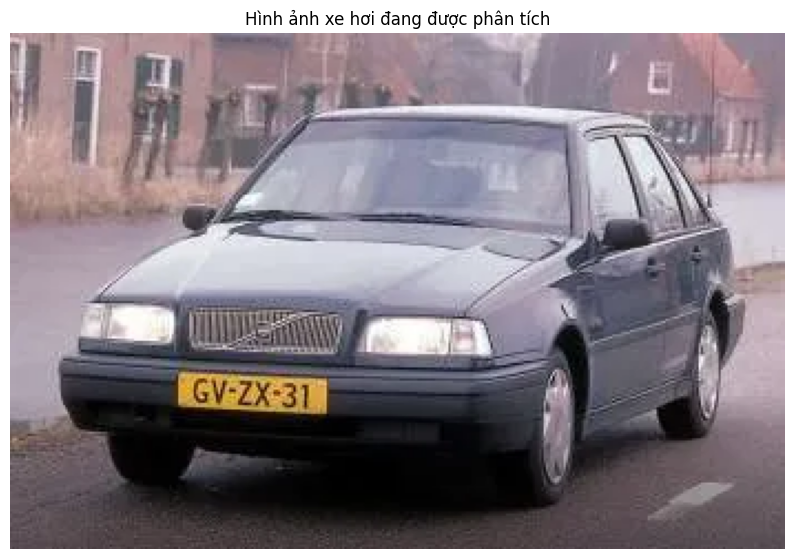


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là sedan .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu đen .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng volvo .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang chạy trên đường .

5. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

6. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: Hãng xe Volvo có xuất xứ từ Thụy Điển

Bạn có thể tải lên hình ảnh khác để phân tích.


In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import files
from pyvi import ViTokenizer
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

# Đường dẫn đến mô hình đã lưu
MODEL_PATH = '/content/drive/MyDrive/Project_Gki/best_Pretrain_Attention_model.pth'

# Danh sách câu hỏi mẫu
sample_questions = [
    "Đây là loại xe gì?",
    "Màu sắc của xe là gì?",
    "Xe này được sản xuất bởi hãng nào?",
    "Xe trong ảnh đang ở đâu?",
    "Đây có phải là xe thể thao không?",
    "Hãng xe này có xuất xứ từ quốc gia nào?",
]
VOCAB_SIZE = len(token_to_id)
EMBED_SIZE = 256
HIDDEN_SIZE = 512
IMG_DIM = 512
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005
ACCUMULATION_STEPS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hàm để tải lại mô hình
def load_model(model_path):
    model = VQAModel(
        vocab_size=VOCAB_SIZE,
        embed_size=EMBED_SIZE,
        hidden_size=HIDDEN_SIZE,
        img_dim=IMG_DIM,
        fine_tune=False,  # Không cần fine_tune khi dự đoán
        dropout=0
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Hàm tiền xử lý hình ảnh
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title("Hình ảnh xe hơi đang được phân tích")
    plt.show()

    # Áp dụng biến đổi giống như test_transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

# Hàm xử lý câu hỏi
def process_question(question, token_to_id):
    tokens = ViTokenizer.tokenize(question.lower()).split()
    token_ids = [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]
    return torch.tensor(token_ids).unsqueeze(0).to(device)

def predict_answer(model, image, question, question_len, token_to_id, id_to_token, max_len=20, question_str=None):
    # Danh sách quốc gia hợp lệ
    valid_countries = {
        "thụy điển": "Thụy Điển",
        "đức": "Đức",
        "nhật bản": "Nhật Bản",
        "mỹ": "Mỹ",
        "hàn quốc": "Hàn Quốc",
        "anh": "Anh",
        "pháp": "Pháp",
        "ý": "Ý"
    }

    with torch.no_grad():
        img_features = model.image_encoder(image)
        question_features = model.question_encoder(question, torch.tensor([question_len]).to(device))
        attended_img = model.attention(img_features.unsqueeze(1), question_features)
        fused_features = model.fusion(torch.cat([attended_img, question_features], dim=1))

        hidden = fused_features
        cell = torch.zeros_like(hidden).to(device)
        decoder_input = torch.tensor([token_to_id['<sos>']]).unsqueeze(0).to(device)

        answer_ids = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell, fused_features)
            pred_token = output.argmax(dim=1).item()
            answer_ids.append(pred_token)
            if pred_token == token_to_id['<eos>']:
                break
            decoder_input = output.argmax(dim=1).unsqueeze(0)

        answer_text = ids_to_text(answer_ids, id_to_token)

        # Hậu xử lý cho câu hỏi về xuất xứ (dùng chuỗi gốc)
        if question_str and "xuất xứ" in question_str.lower():
            answer_lower = answer_text.lower()
            for token, country in valid_countries.items():
                if token in answer_lower:
                    # Sửa lỗi cụ thể cho Volvo
                    if "volvo" in answer_lower:
                        return "Hãng xe Volvo có xuất xứ từ Thụy Điển"
                    return f"Hãng xe có xuất xứ từ {country}"
            print(f"Cảnh báo: Quốc gia không hợp lệ trong câu trả lời: {answer_text}")

        return answer_text

# Hàm ids_to_text (giữ nguyên từ code trước)
def ids_to_text(ids, id_to_token):
    words = []
    for id in ids:
        if id == token_to_id['<eos>']:
            break
        if id not in [token_to_id['<pad>'], token_to_id['<sos>']]:
            word = id_to_token[id].replace('_', ' ')
            words.append(word)
    return ' '.join(words).strip()


# Tải mô hình
print("Đang tải mô hình...")
model = load_model(MODEL_PATH)
print("Đã tải mô hình thành công!")

# Hàm kiểm thử với câu hỏi mẫu tự động
def test_with_sample_questions():
    print("Vui lòng tải lên hình ảnh xe hơi...")
    uploaded = files.upload()

    if not uploaded:
        print("Không có file nào được tải lên.")
        return

    image_path = next(iter(uploaded))
    image_tensor = preprocess_image(image_path)

    print("\n" + "="*50)
    print("KẾT QUẢ PHÂN TÍCH XE HƠI")
    print("="*50)

    for i, question_str in enumerate(sample_questions, 1):
        question_tensor = process_question(question_str, token_to_id)
        question_len = len(question_tensor[0])

        # Truyền cả chuỗi gốc (question_str) và Tensor (question_tensor)
        answer = predict_answer(model, image_tensor, question_tensor, question_len, token_to_id, id_to_token, question_str=question_str)

        print(f"\n{i}. Câu hỏi: {question_str}")
        print(f"   Câu trả lời: {answer}")

    print("\n" + "="*50)
    print("Bạn có thể tải lên hình ảnh khác để phân tích.")

# Bạn cũng có thể thêm tùy chọn để kiểm thử với một hình ảnh có sẵn
def test_with_fixed_image(image_path="/content/stanford_cars/cars_test/cars_test/01005.jpg"):
    print(f"Đang kiểm thử với hình ảnh cố định: {image_path}")

    if not os.path.exists(image_path):
        print(f"Không tìm thấy hình ảnh tại đường dẫn: {image_path}")
        return

    image_tensor = preprocess_image(image_path)

    print("\n" + "="*50)
    print("KẾT QUẢ PHÂN TÍCH XE HƠI")
    print("="*50)

    for i, question in enumerate(sample_questions, 1):
        question_tensor = process_question(question, token_to_id)
        question_len = len(question_tensor[0])

        # Dự đoán câu trả lời
        answer = predict_answer(model, image_tensor, question_tensor, question_len, token_to_id, id_to_token)

        print(f"\n{i}. Câu hỏi: {question}")
        print(f"   Câu trả lời: {answer}")

    print("\n" + "="*50)

# Chọn một trong hai hàm để chạy:
# 1. Để tải lên hình ảnh mới:
test_with_sample_questions()

# 2. Hoặc để kiểm thử với hình ảnh có sẵn (bỏ comment dòng dưới đây):
#test_with_fixed_image()

Đang tải mô hình...
Đã tải mô hình thành công!
Tìm thấy 8041 ảnh trong thư mục test.


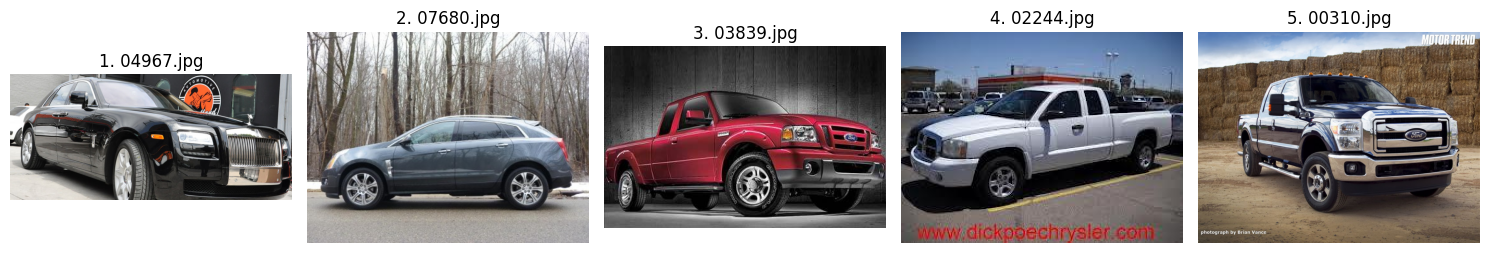


Chọn một ảnh để phân tích:



Đang phân tích ảnh: 04967.jpg


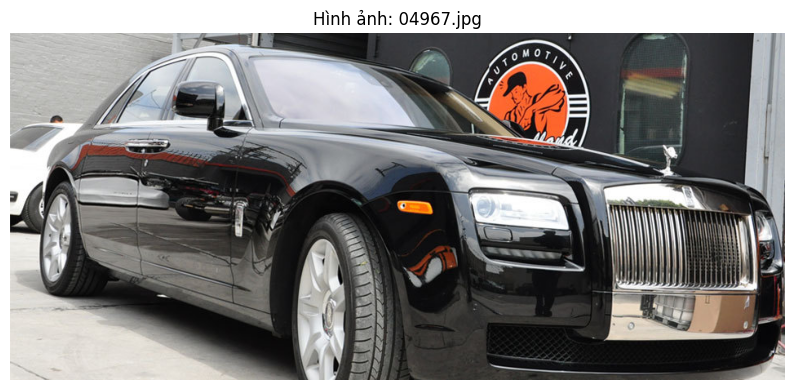


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là sedan .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu đen .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng rolls - royce .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang được cận cảnh , chiếm phần lớn khung hình .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: có , đây là xe sang với thiết kế cao cấp và nhiều tính năng hiện đại .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe rolls - royce có xuất xứ từ anh .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này sang trọng và tinh tế , thể hiện đẳng cấp cao cấp .


Đang phân tích ảnh: 02244.jpg


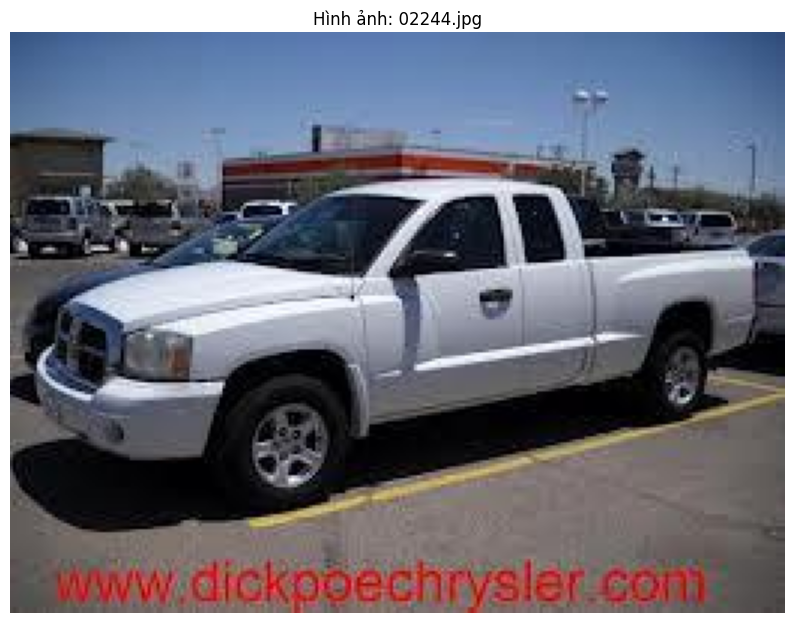


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là hatchback . tải .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu trắng .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng chevrolet .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang đỗ trong bãi đỗ xe .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: không , đây không phải là xe sang mà thuộc phân khúc phổ thông .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe chevrolet có xuất xứ từ mỹ .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này hiện đại và cân đối , phù hợp với phân khúc của nó .


Đang phân tích ảnh: 03931.jpg


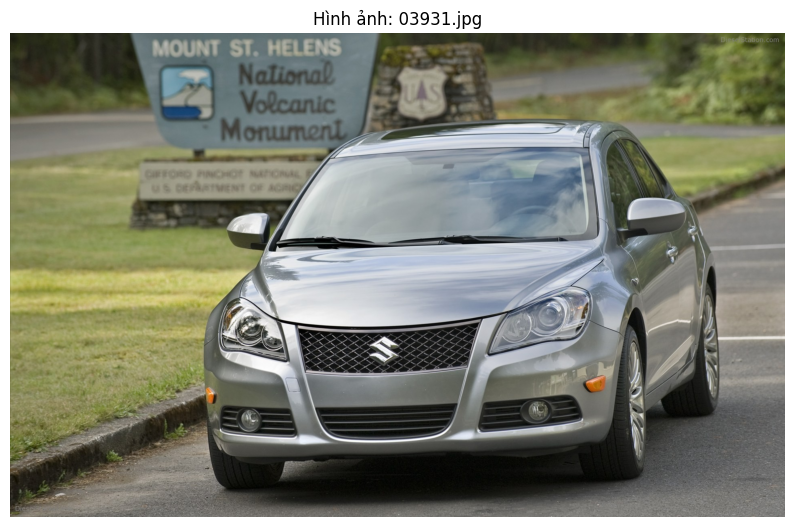


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là sedan .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu bạc .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng acura .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang chạy trên đường .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: không , đây không phải là xe sang mà thuộc phân khúc phổ thông .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe acura có xuất xứ từ nhật bản

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này hiện đại và cân đối , phù hợp với phân khúc của nó .


Đang phân tích ảnh: 06942.jpg


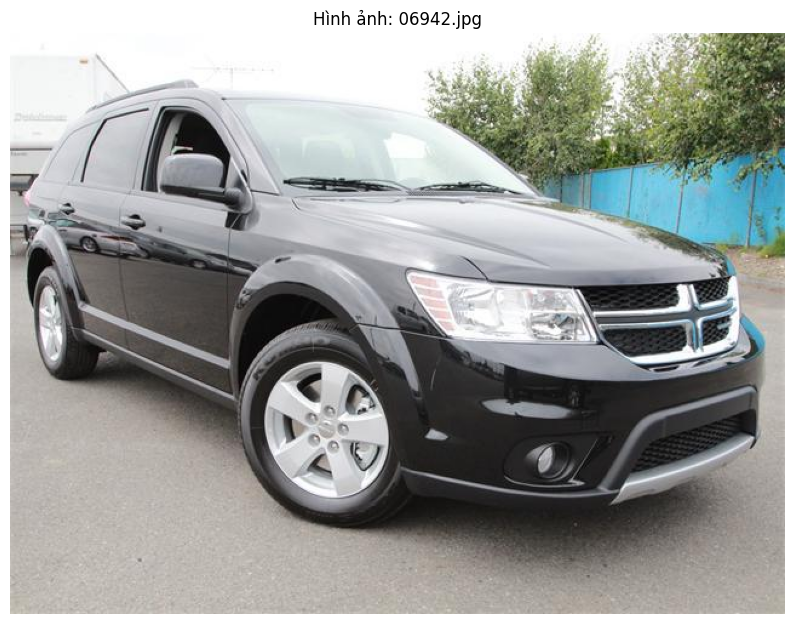


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là suv .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu đen .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng dodge .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang đỗ trong bãi đỗ xe .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: không , đây không phải là xe sang mà thuộc phân khúc phổ thông .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe dodge có xuất xứ từ mỹ .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này mạnh mẽ và khỏe khoắn , phù hợp với đặc tính một chiếc suv .


Đang phân tích ảnh: 01038.jpg


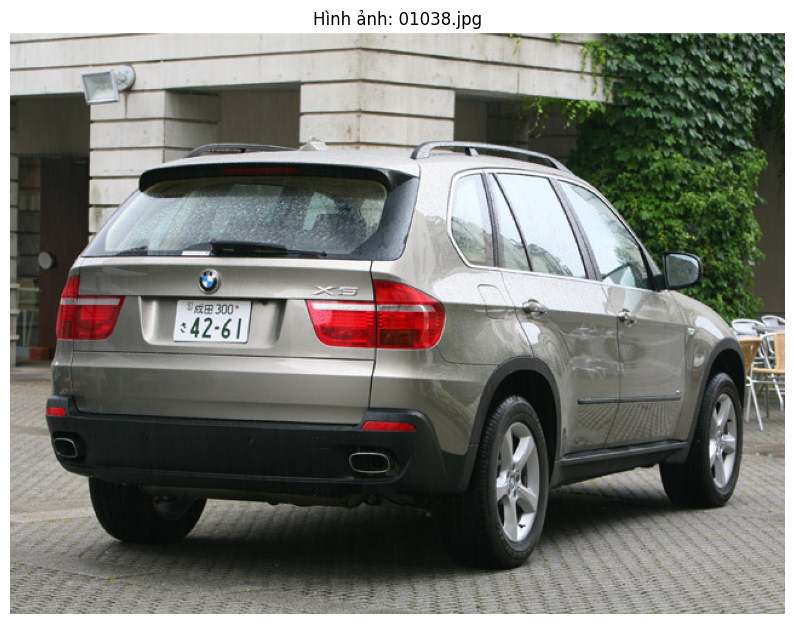


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là suv .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu bạc .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng bmw .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang chạy trên đường .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: có , đây là xe sang với thiết kế cao cấp và nhiều tính năng hiện đại .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe bmw có xuất xứ từ đức .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này sang trọng và tinh tế , thể hiện đẳng cấp cao cấp .


Đang phân tích ảnh: 02034.jpg


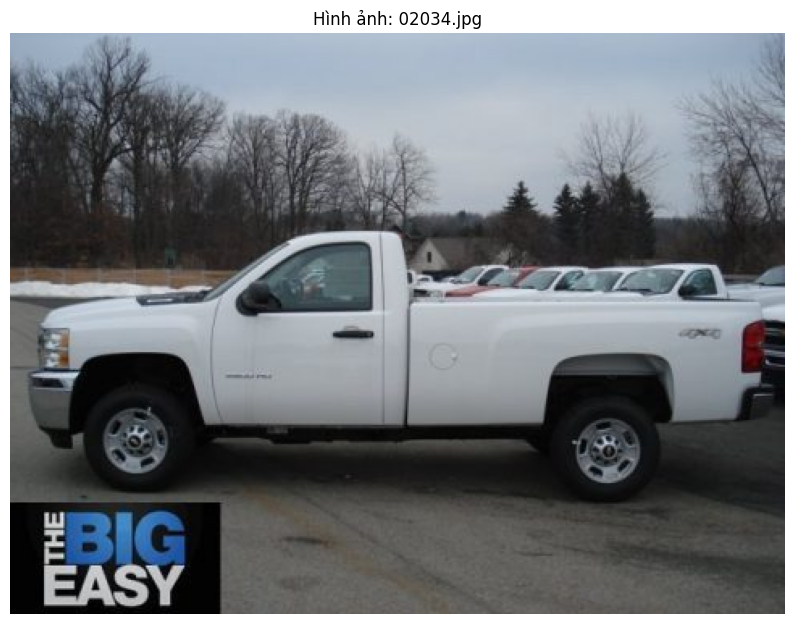


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là hatchback .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu trắng .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng chevrolet .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang đỗ trong bãi đỗ xe .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: không , đây không phải là xe sang mà thuộc phân khúc phổ thông .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe chevrolet có xuất xứ từ mỹ .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này hiện đại và cân đối , phù hợp với phân khúc của nó .


Đang phân tích ảnh: 05358.jpg


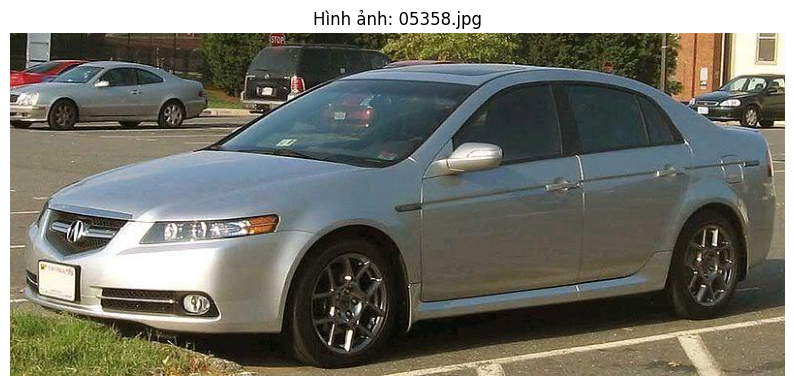


KẾT QUẢ PHÂN TÍCH XE HƠI

1. Câu hỏi: Đây là loại xe gì?
   Câu trả lời: đây là sedan .

2. Câu hỏi: Màu sắc của xe là gì?
   Câu trả lời: xe có màu bạc .

3. Câu hỏi: Xe này được sản xuất bởi hãng nào?
   Câu trả lời: xe này được sản xuất bởi hãng acura .

4. Câu hỏi: Xe trong ảnh đang ở đâu?
   Câu trả lời: xe đang chạy trên đường .

5. Câu hỏi: Đây có phải là xe sang không?
   Câu trả lời: không , đây không phải là xe sang mà thuộc phân khúc phổ thông .

6. Câu hỏi: Đây có phải là xe thể thao không?
   Câu trả lời: không , đây không phải là xe thể thao .

7. Câu hỏi: Hãng xe này có xuất xứ từ quốc gia nào?
   Câu trả lời: hãng xe acura có xuất xứ từ nhật bản .

8. Câu hỏi: Bạn đánh giá thế nào về thiết kế của xe này?
   Câu trả lời: thiết kế của xe này hiện đại và mượt mà , phù hợp với phân khúc của nó .



In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from pyvi import ViTokenizer
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from IPython.display import display
import ipywidgets as widgets

# Đường dẫn đến mô hình đã lưu
MODEL_PATH = '/content/drive/MyDrive/Project_Gki/best_Pretrain_Attention_model.pth'

# Đường dẫn đến thư mục test
TEST_DIR = "/content/stanford_cars/cars_test/cars_test"

# Danh sách câu hỏi mẫu
sample_questions = [
    "Đây là loại xe gì?",
    "Màu sắc của xe là gì?",
    "Xe này được sản xuất bởi hãng nào?",
    "Xe trong ảnh đang ở đâu?",
    "Đây có phải là xe sang không?",
    # "Đây có phải là xe thể thao không?",
    "Hãng xe này có xuất xứ từ quốc gia nào?",
    # "Bạn đánh giá thế nào về thiết kế của xe này?"
]

# # Hàm để tải lại mô hình
# def load_model(model_path):
#     model = VQAModel(
#         vocab_size=VOCAB_SIZE,
#         embed_size=EMBED_SIZE,
#         hidden_size=HIDDEN_SIZE,
#         img_dim=IMG_DIM,
#         fine_tune=False,  # Không cần fine_tune khi dự đoán
#         dropout=0
#     )
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.to(device)
#     model.eval()
#     return model

# Hàm tiền xử lý hình ảnh
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title(f"Hình ảnh: {os.path.basename(image_path)}")
    plt.show()

    # Áp dụng biến đổi giống như test_transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

# Các hàm xử lý câu hỏi và câu trả lời (giữ nguyên từ code trước)
def process_question(question, token_to_id):
    tokens = ViTokenizer.tokenize(question.lower()).split()
    token_ids = [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]
    return torch.tensor(token_ids).unsqueeze(0).to(device)

def ids_to_text(ids, id_to_token):
    words = []
    for id in ids:
        if id == token_to_id['<eos>']:
            break
        if id not in [token_to_id['<pad>'], token_to_id['<sos>']]:
            word = id_to_token[id].replace('_', ' ')  # Thay dấu gạch ngang bằng dấu cách
            words.append(word)
    return ' '.join(words)

def predict_answer(model, image, question, question_len, token_to_id, id_to_token, max_len=20):
    with torch.no_grad():
        img_features = model.image_encoder(image)
        question_features = model.question_encoder(question, torch.tensor([question_len]).to(device))
        attended_img = model.attention(img_features.unsqueeze(1), question_features)
        fused_features = model.fusion(torch.cat([attended_img, question_features], dim=1))

        hidden = fused_features
        cell = torch.zeros_like(hidden).to(device)
        decoder_input = torch.tensor([token_to_id['<sos>']]).unsqueeze(0).to(device)

        answer_ids = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell, fused_features)
            pred_token = output.argmax(dim=1).item()
            answer_ids.append(pred_token)

            if pred_token == token_to_id['<eos>']:
                break

            decoder_input = output.argmax(dim=1).unsqueeze(0)

        answer_text = ids_to_text(answer_ids, id_to_token)
        return answer_text

# Tải mô hình
print("Đang tải mô hình...")
model = load_model(MODEL_PATH)
print("Đã tải mô hình thành công!")

# Hàm để liệt kê tất cả các file ảnh trong thư mục test
def get_test_images(test_dir):
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = []

    if os.path.exists(test_dir):
        for file in os.listdir(test_dir):
            ext = os.path.splitext(file)[1].lower()
            if ext in image_extensions:
                image_files.append(os.path.join(test_dir, file))

        print(f"Tìm thấy {len(image_files)} ảnh trong thư mục test.")
    else:
        print(f"Không tìm thấy thư mục: {test_dir}")

    return image_files

# Hiển thị ảnh mẫu ngẫu nhiên để lựa chọn
def show_sample_test_images(image_files, num_samples=5):
    if len(image_files) == 0:
        print("Không có ảnh nào để hiển thị!")
        return []

    samples = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(samples):
        plt.subplot(1, len(samples), i+1)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"{i+1}. {os.path.basename(img_path)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return samples

# Hàm test cho một ảnh cụ thể
def test_single_image(image_path):
    print(f"\nĐang phân tích ảnh: {os.path.basename(image_path)}")
    image_tensor = preprocess_image(image_path)

    print("\n" + "="*50)
    print("KẾT QUẢ PHÂN TÍCH XE HƠI")
    print("="*50)

    for i, question in enumerate(sample_questions, 1):
        question_tensor = process_question(question, token_to_id)
        question_len = len(question_tensor[0])

        # Dự đoán câu trả lời
        answer = predict_answer(model, image_tensor, question_tensor, question_len, token_to_id, id_to_token)

        print(f"\n{i}. Câu hỏi: {question}")
        print(f"   Câu trả lời: {answer}")

    print("\n" + "="*50)

# Phiên bản sử dụng widget để tương tác thay vì input()
def test_with_images_using_widgets():
    image_files = get_test_images(TEST_DIR)
    if len(image_files) == 0:
        return

    # Hiển thị 5 ảnh mẫu
    sample_images = show_sample_test_images(image_files)

    # Tạo widget để chọn ảnh mẫu
    sample_buttons = []
    for i in range(len(sample_images)):
        btn = widgets.Button(description=f'Ảnh {i+1}')
        btn.image_path = sample_images[i]

        def on_sample_click(b):
            test_single_image(b.image_path)

        btn.on_click(on_sample_click)
        sample_buttons.append(btn)

    # Nút chọn ảnh ngẫu nhiên
    random_btn = widgets.Button(description='Ảnh ngẫu nhiên')

    def on_random_click(b):
        random_image = random.choice(image_files)
        test_single_image(random_image)

    random_btn.on_click(on_random_click)

    # Hiển thị tất cả các nút
    print("\nChọn một ảnh để phân tích:")

    # Thêm nút ngẫu nhiên vào danh sách
    all_buttons = sample_buttons + [random_btn]

    # Hiển thị các nút theo hàng
    button_row1 = widgets.HBox(sample_buttons)
    button_row2 = widgets.HBox([random_btn])
    display(button_row1)
    display(button_row2)

# Chạy hàm chính sử dụng widget
test_with_images_using_widgets()